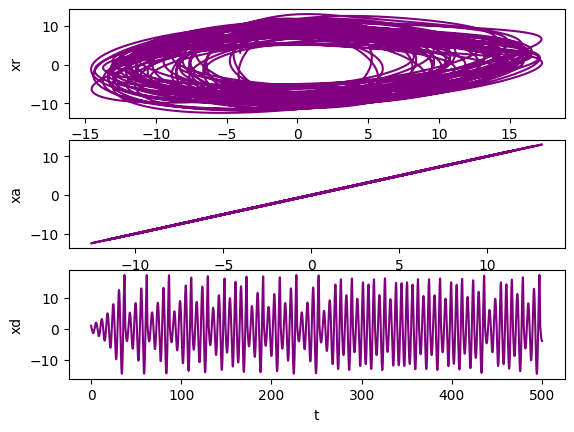

In [131]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

a = 0.15;
p = 0.2;
c = 10.0;
wr = 0.95;
wd = 0.99;
e = 0.13;

def rossler(H, t=0):
    return np.array([(-wd*H[1])-H[2], #xd 0
                    (wd*H[0])+(a*H[1]), #yd 1
                    p+(H[2]*(H[0]-c)), #zd 2 
                    ((-wr*H[4])-H[5])+e*(H[0]-H[3]), #xr 3
                    (wr*H[3])+(a*H[4]), #yr 4 
                    p+(H[5]*(H[3]-c)), #zr 5
                    (((-wr*H[7])-H[8])+e*(H[0]-H[6])), #xa 6
                    ((wr*H[6])+(a*H[7])), #ya 7 
                    p+(H[8]*(H[6]-c))]) #za 8 
                    

T = 1000000; T0 = 400000;
t = np.linspace(0, 500, T)
#t = np.linspace(0, T/2, T)
#t = np.arange(0.1, 10000, 0.01)
#T0 = 920000


#H0 = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.1, 0.1, 0.1]
H0 = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.05, 1.05, 1.05 ]
#H0 = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001,]
H, infodict = integrate.odeint(rossler, H0, t, full_output=True)

fig, axs = plt.subplots(3)
axs[0].plot(H[T0:,0],H[T0:,3],c='purple') #xd xr
axs[1].plot(H[T0:,3],H[T0:,6],c='purple') #xr,xa
axs[2].plot(t,H[:,0],c='purple')

#plt.plot(H[:,3],H[:,6],c='purple') #xr,xa
#plt.plot(H[1000:,0],H[1000:,3],c='purple')
plt.setp(axs[0], xlabel='xd')
plt.setp(axs[0], ylabel='xr')
plt.setp(axs[1], xlabel='xr')
plt.setp(axs[1], ylabel='xa')
plt.setp(axs[2], xlabel='t')
plt.setp(axs[2], ylabel='xd')
plt.show()
#v = np.array(np.meshgrid(H[T0:,0], H[T0:,3])).T.reshape(-1, 2)
#v = np.array(np.meshgrid(H[T0:,3], t[T0:])).T.reshape(-1, 2)
#print(t[T0:])
#np.savetxt('xt.csv', v, delimiter=",")

#print(len(H[T0:,0]))







In [132]:
q = np.vstack((H[T0:,3],t[T0:])).T
df = pd.DataFrame(q, columns = ['x','t'])

df1 = pd.DataFrame(H[T0:,3])
print(df)
print(df1)

               x         t
0       1.857486  200.0002
1       1.854413  200.0007
2       1.851339  200.0012
3       1.848265  200.0017
4       1.845191  200.0022
...          ...       ...
599995  3.104625  499.9980
599996  3.100259  499.9985
599997  3.095892  499.9990
599998  3.091524  499.9995
599999  3.087156  500.0000

[600000 rows x 2 columns]
               0
0       1.857486
1       1.854413
2       1.851339
3       1.848265
4       1.845191
...          ...
599995  3.104625
599996  3.100259
599997  3.095892
599998  3.091524
599999  3.087156

[600000 rows x 1 columns]


In [133]:
#sns.lineplot(x='t', y='x', data=df)

In [134]:
#df1.plot()

In [135]:
t1 = t[T0:]
print(t1)

[200.0002 200.0007 200.0012 ... 499.999  499.9995 500.    ]


In [136]:
def df_to_X_y(df,t, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row=[a for a in df_as_np[i:i+5]]
    X.append(row)
    label=df_as_np[i+5]
    y.append(label)
  return np.array(X),np.array(y)

In [137]:
WINDOW_SIZE = 5
X,y = df_to_X_y(df1,t1,WINDOW_SIZE)
X.shape, y.shape

((599995, 5, 1), (599995, 1))

In [138]:
y=y.flatten()

In [139]:
X_train, y_train = X[:500000], y[:500000]
X_val, y_val = X[500000:550000], y[500000:550000]
X_test, y_test = X[550000:], y[550000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((500000, 5, 1), (500000,), (50000, 5, 1), (50000,), (49995, 5, 1), (49995,))

In [140]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [141]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [142]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[cp1])

Epoch 1/5
15622/15625 [============================>.] - ETA: 0s - loss: 0.8168 - root_mean_squared_error: 0.9037

15625/15625 [==============================] - 92s 6ms/step - loss: 0.8166 - root_mean_squared_error: 0.9037 - val_loss: 8.9160e-05 - val_root_mean_squared_error: 0.0094
Epoch 2/5
15621/15625 [============================>.] - ETA: 0s - loss: 9.2903e-05 - root_mean_squared_error: 0.0096

15625/15625 [==============================] - 87s 6ms/step - loss: 9.2898e-05 - root_mean_squared_error: 0.0096 - val_loss: 6.8089e-05 - val_root_mean_squared_error: 0.0083
Epoch 3/5
15622/15625 [============================>.] - ETA: 0s - loss: 6.8623e-05 - root_mean_squared_error: 0.0083

15625/15625 [==============================] - 86s 6ms/step - loss: 6.8619e-05 - root_mean_squared_error: 0.0083 - val_loss: 5.4767e-05 - val_root_mean_squared_error: 0.0074
Epoch 4/5
15624/15625 [============================>.] - ETA: 0s - loss: 5.8007e-05 - root_mean_squared_error: 0.0076

15625/15625 [==============================] - 91s 6ms/step - loss: 5.8005e-05 - root_mean_squared_error: 0.0076 - val_loss: 3.6031e-05 - val_root_mean_squared_error: 0.0060
Epoch 5/5
15625/15625 [==============================] - 91s 6ms/step - loss: 5.0964e-05 - root_mean_squared_error: 0.0071 - val_loss: 6.0879e-05 - val_root_mean_squared_error: 0.0078


In [143]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [144]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

15625/15625 [==============================] - 41s 3ms/step


,Train Predictions,Actuals
0,1.845459,1.842116
1,1.842381,1.839041
2,1.839303,1.835966
3,1.836225,1.832890
4,1.833147,1.829814
...,...,...
499995,6.673212,6.670051
499996,6.672088,6.668928
499997,6.670961,6.667802
499998,6.669833,6.666675


In [145]:
#plt.plot(train_results['Train Predictions'],'.')
#plt.plot(train_results['Actuals'],c='black')

In [146]:
#val_predictions = model1.predict(X_val).flatten()
#val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
#val_results

In [147]:
#plt.plot(val_results['Val Predictions'])
#plt.plot(val_results['Actuals'],'.')

In [148]:
#test_predictions = model1.predict(X_test).flatten()
#test_results = pd.DataFrame(data={'test Predictions':test_predictions, 'Actuals':y_test})
#test_results


In [149]:
#plt.plot(test_results['test Predictions'])
#plt.plot(test_results['Actuals'],'.')

In [150]:
#from sklearn.metrics import mean_squared_error as mse
'''
def plot_predictions1(model, X, y):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'])
  plt.plot(df['Actuals'])
  return df, mse(y, predictions)'''

"\ndef plot_predictions1(model, X, y):\n  predictions = model.predict(X).flatten()\n  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})\n  plt.plot(df['Predictions'])\n  plt.plot(df['Actuals'])\n  return df, mse(y, predictions)"

In [151]:
#plot_predictions1(model1, X_test, y_test)

In [152]:
#pred = model1.predict(X_test)
#pred = pd.DataFrame(pred)
#pred.to_csv(f"test_out2.csv",index=False,header=None)

In [153]:
pred1 = model1.predict(X_train)
pred1 = pd.DataFrame(pred1)
pred1.to_csv(f"xr_003.csv",index=False,header=None)

15625/15625 [==============================] - 40s 3ms/step


In [154]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [155]:
import tensorflow_addons as tfa
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_train, train_predictions)
result = metric.result()
result.numpy()

0.9999991

In [156]:
import tensorflow_addons as tfa
metric = tfa.metrics.r_square.RSquare()
metric.update_state(train_predictions,y_train)
result = metric.result()
result.numpy()

0.9999991